# hyperparameter

In [1]:
# 设置超参数
epochs = 100

# batch_size/ learning_rate 扩大的倍数
batch_n = 10
batch_size = 64*batch_n

# learning_rate
learning_rate = 0.001

# warm up 数
warm_up_epochs = 3

# 早停参数
no_better_stop = 15

# 随机遮蔽
random_mask = 0
random_mask_row = 0

# 是否使用混合精度
amp = False

label_smoothing=0.1

weight_decay=0.01

# 测试最优学习率
# 非训练使用
init_learning_ratio=0
increase_ratio=0.2

data_set = '20240502_平均价格2_n15_pass100_3分类_24x3_2品种.zip'

title = 'D_n15_p100'

# func dataset

In [2]:
!pip install "pandas<2.0.0"
!pip install loguru
!pip install dill
!pip install torchinfo
!pip install dataframe_image
!pip install https://raw.githubusercontent.com/lhiqwj173/dl_help_data/master/py_ext-1.0.0-py3-none-any.whl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 62.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.6 which is incompatible.
cudf 23.8.0 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.

In [3]:
import shutil, os, zipfile, sys, requests

# 下载依赖文件
!wget -O model_func.py https://raw.githubusercontent.com/lhiqwj173/dl_help_data/master/model_func.py
from model_func import set_golbal_var, Dataset, re_blance_sample, read_data, batch_gd, deeplob, test_model, predict_test_y, plot_roc, test_ps

--2024-05-02 09:03:00--  https://raw.githubusercontent.com/lhiqwj173/dl_help_data/master/model_func.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53233 (52K) [text/plain]
Saving to: 'model_func.py'

model_func.py       100%[===================>]  51.99K  --.-KB/s    in 0.01s   

2024-05-02 09:03:00 (4.28 MB/s) - 'model_func.py' saved [53233/53233]



In [4]:
# 下载数据并解压
data_path = './data/'
os.makedirs(data_path, exist_ok=True)
response = requests.get(f'https://github.com/lhiqwj173/dl_help_data/raw/master/{data_set}')
if response.status_code == 200:
    with open('./data/data.zip', 'wb') as file:
        file.write(response.content)
else:
    print("Failed to download file")
with zipfile.ZipFile('./data/data.zip', 'r') as zip_ref:
    zip_ref.extractall(data_path)

# # 本地数据
# data_path = '/kaggle/input/n5-pass100'    

# notebook

In [5]:
from tqdm import tqdm
import pandas as pd
import pickle, os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve as roc
from sklearn.metrics import roc_auc_score as auc
import multiprocessing
import math

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 功能函数
import sys

from py_ext.wechat import wx
wx.send_message("kaggle 开始运行")

# 捕捉异常
from IPython import get_ipython
def custom_exception_handler(exctype, value, traceback):
    msg = f"kaggle 异常: , {exctype}, {value}"
    wx.send_message(msg)
# Override the default sys.excepthook with the custom handler function
get_ipython().set_custom_exc((Exception,), custom_exception_handler)

from loguru import logger as _logger
class logger:
  @staticmethod
  def debug(*args):
    _logger.debug(*args)

  @staticmethod
  def add(*args):
    _logger.add(*args)
    
root = './'
    
# 运行变量
os.makedirs(os.path.join(root, 'var'), exist_ok=True)

# log
os.makedirs(os.path.join(root, 'log'), exist_ok=True)
logger.add(os.path.join(root, 'log', f'{datetime.now().strftime("%Y%m%d_%H%M%S")}.log'))

# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.debug(device)

# cpu核数
import multiprocessing
workers = int(multiprocessing.cpu_count())
logger.debug(f'workers: {workers}')

cache_epoch = 10000000

# 传递全局变量
set_golbal_var(root, data_path, epochs, batch_n, batch_size, learning_rate, warm_up_epochs, device, workers, logger, wx, no_better_stop, amp, random_mask, random_mask_row, weight_decay, label_smoothing, title, init_learning_ratio, increase_ratio, cache_epoch)

# 读取训练数据
train_loader = read_data('train', shuffle=True)
val_loader = read_data('val')
logger.debug(f"train:{len(train_loader)}, val:{len(val_loader)}")

model = deeplob(y_len = 3)
logger.debug(str(model))

# 将模型移动到GPU上
model = model.to(device)

input = torch.randn((1, 1, 70, 46)).to(device)
flops, params = profile(model, inputs=(input,))
flops, params = clever_format([flops, params])
logger.debug(f"FLOPs: {flops} Params: {params}")

2024-05-02 09:03:30.174 | DEBUG    | __main__:debug:41 - cuda
2024-05-02 09:03:30.175 | DEBUG    | __main__:debug:41 - workers: 4


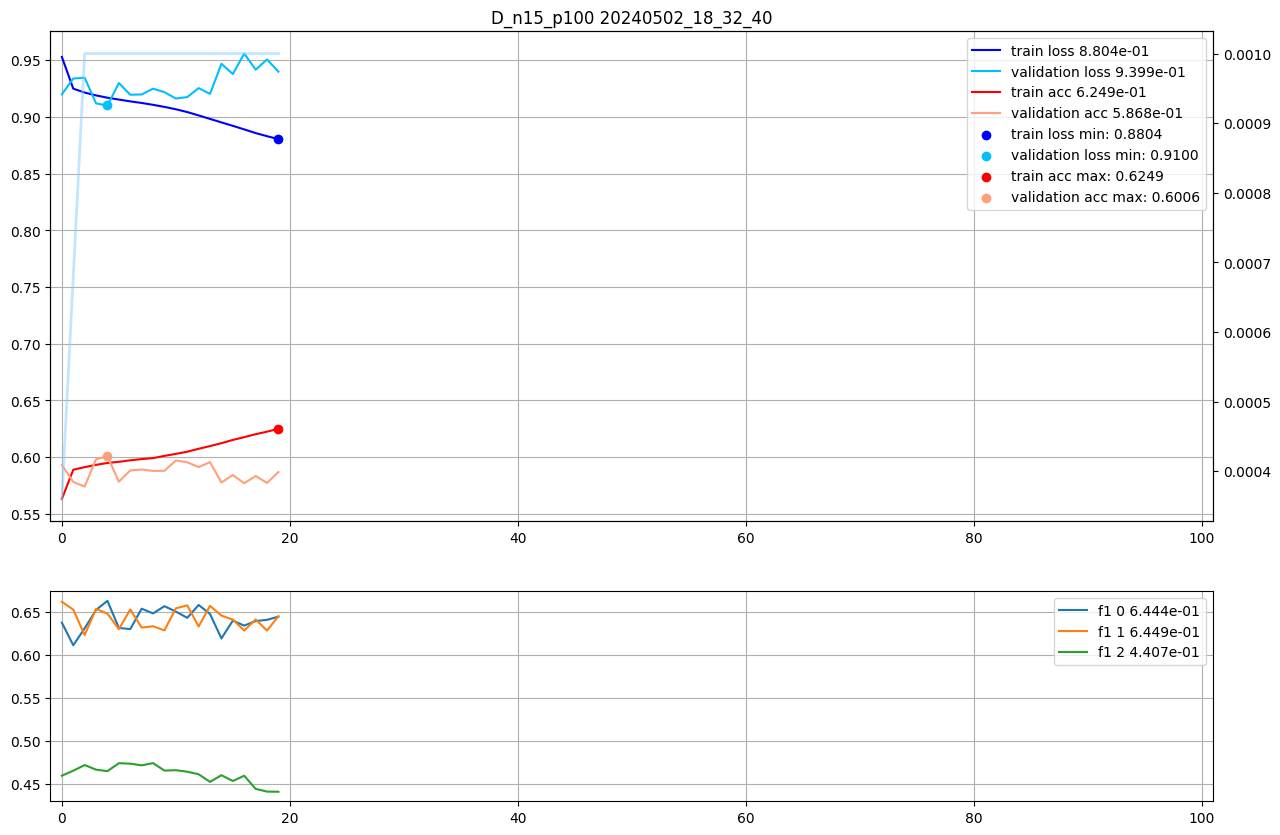

(0.8804066863300385,
 0.9100374413228746,
 0.6249158707775143,
 0.6006195943734908)

In [9]:
# 开启CuDNN自动优化
torch.backends.cudnn.benchmark = True

# gpu 数量
if torch.cuda.device_count() > 1:
    logger.debug("使用多gpu")
    model = nn.DataParallel(model)

criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
optimizer_class = torch.optim.AdamW

# 学习率调整策略
warm_up_with_cosine_lr = lambda epoch: epoch / warm_up_epochs if epoch < warm_up_epochs else 0.5 * ( math.cos((epoch - warm_up_epochs) /(epochs - warm_up_epochs) * math.pi) + 1)

# store best [train_loss,val_loss,train_acc,val_acc]
result_dict = {}
batch_gd(model, criterion, optimizer_class, None, train_loader, val_loader, epochs=epochs, result_dict=result_dict)

# 测试模型
test_loader = read_data('test')
test_model(test_loader)

# 更新试验结果
import os
result_file = os.path.join(root, 'result.csv')
if not os.path.exists(result_file):
    # 初始化列名
    with open(result_file, 'w') as f:
        f.write('time,epochs,batch_n,batch_size,learning_rate,warm_up_epochs,no_better_stop,random_mask,random_mask_row,amp,label_smoothing,weight_decay,,train_loss,val_loss,train_acc,val_acc\n')
# 写入结果
with open(result_file, 'a') as f:
    f.write(f'{datetime.now().strftime("%Y%m%d_%H%M%S")},{epochs},{batch_n},{batch_size},{learning_rate},{warm_up_epochs},{no_better_stop},{random_mask},{random_mask_row},{amp},{label_smoothing},{weight_decay},,{result_dict["train_loss"]},{result_dict["val_loss"]},{result_dict["train_acc"]},{result_dict["val_acc"]}\n')

# 删除 data 目录
if os.path.exists(os.path.join(root, 'data')):
    shutil.rmtree(os.path.join(root, 'data'))

# 结束
wx.send_message("kaggle 运行完毕")

'ok'